In [1]:
import os
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Cambiar directorio
# os.chdir("..")

In [3]:
# Cargar los datos que tenemos disponibles
data = pd.read_csv("../data/churn.csv")


In [4]:
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
# Nos deshacemos de las columnas que no contribuyen en mucho
data = data.drop(data.columns[0:3], axis=1)
data.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
# Convertimos los datos en formato categorico, para más info: shorturl.at/y0269
column_equivalence = {}
features = list(data.columns)
for i, column in enumerate(list([str(d) for d in data.dtypes])):
    if column == "object":
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].mode())
        categorical_column = data[data.columns[i]].astype("category")
        current_column_equivalence = dict(enumerate(categorical_column.cat.categories))
        column_equivalence[i] = dict((v,k) for k,v in current_column_equivalence.items())
        data[data.columns[i]] = categorical_column.cat.codes
    else:
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].median())

In [7]:
column_equivalence

{1: {'France': 0, 'Germany': 1, 'Spain': 2}, 2: {'Female': 0, 'Male': 1}}

In [8]:
count_False, count_True = data['Exited'].value_counts()
count_False, count_True

(7963, 2037)

In [9]:
df_False = data[data["Exited"] == 0]
df_True = data[data["Exited"] == 1]
df_False.shape, df_True.shape

((7963, 11), (2037, 11))

In [10]:
df_True_over = df_True.sample(count_False, replace = True)
df_False.shape, df_True_over.shape

((7963, 11), (7963, 11))

In [11]:
data_os = pd.concat([df_False, df_True_over], axis = 0)
print(data['Exited'].value_counts())

0    7963
1    2037
Name: Exited, dtype: int64


In [12]:
data.shape

(10000, 11)

In [13]:
data_os['Exited'].value_counts()

0    7963
1    7963
Name: Exited, dtype: int64

<Axes: >

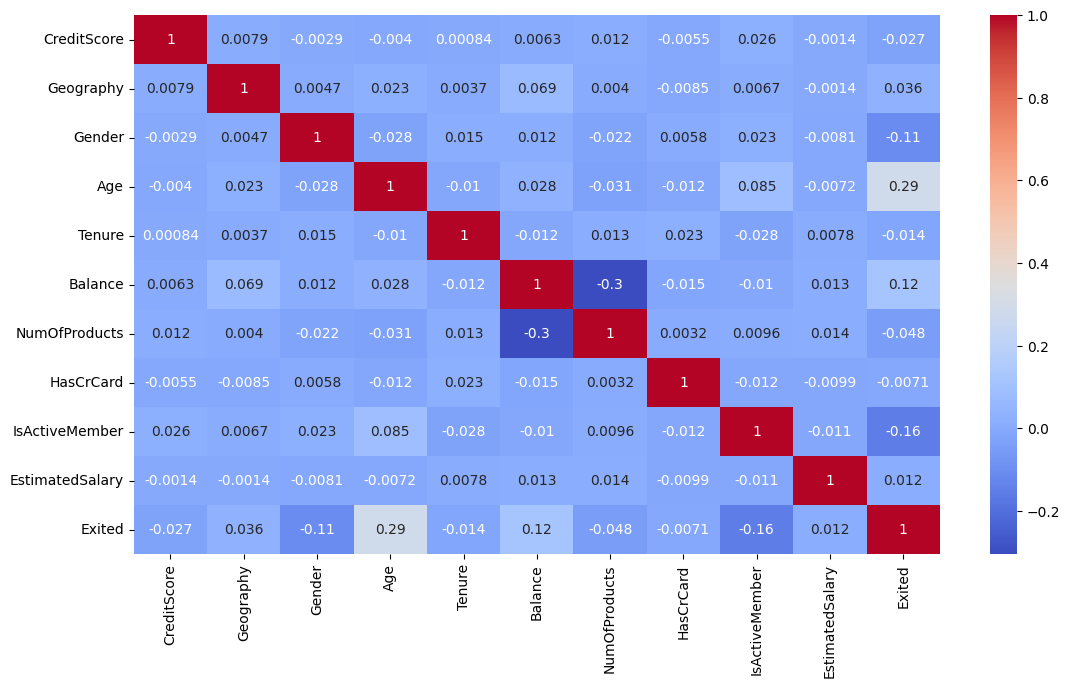

In [14]:
plt.figure(figsize=(13,7))
sns.heatmap(data.corr(),annot=True,cmap='coolwarm')

In [15]:
# Generar los datos para poder separar la variable de respuesta de los datos que tenemos disponibles
X = data.copy()
y = X.pop(data.columns[-1])

In [16]:
y.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [17]:
# Separar los datos en datos de entrenamiento y testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
param_grid = {
    'n_estimators': [20,40,80,100,160],
    'criterion': ["gini", "entropy", "log_loss"],
    'max_depth': [None,1,2,4,6,10],
    'min_samples_split': [2,4,6,8],
    'class_weight': [None,"balanced", "balanced_subsample"]
}

In [20]:
# Crear el modelo y entrenarlo
clf_lin =  RandomForestClassifier(random_state=42)


In [21]:
grid_search = GridSearchCV(clf_lin, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'class_weight': [None, 'balanced',
                                          'balanced_subsample'],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 1, 2, 4, 6, 10],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [20, 40, 80, 100, 160]})

In [22]:
print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 8, 'n_estimators': 160}


In [23]:
clf_lin = grid_search.best_estimator_   

In [24]:
y_pred = clf_lin.predict(X_test)
y_pred.shape, y_test.shape, (y_pred-y_test).sum()

((3300,), (3300,), -263)

In [25]:
clf_lin.score(X_train,y_train)

0.9450746268656717

In [26]:
clf_lin.score(X_test,y_test)

0.8687878787878788

In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, grid_search.best_estimator_.predict(X_train))


array([[5280,   26],
       [ 342, 1052]], dtype=int64)

In [27]:
# Medir los resultados obtenidos
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, clf_lin.predict(X_test))


array([[2572,   85],
       [ 348,  295]], dtype=int64)

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_train, clf_lin.predict(X_train)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5306
           1       0.98      0.75      0.85      1394

    accuracy                           0.95      6700
   macro avg       0.96      0.87      0.91      6700
weighted avg       0.95      0.95      0.94      6700



In [29]:
from sklearn.metrics import classification_report
report = classification_report(y_test, clf_lin.predict(X_test))
print(report)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2657
           1       0.78      0.46      0.58       643

    accuracy                           0.87      3300
   macro avg       0.83      0.71      0.75      3300
weighted avg       0.86      0.87      0.86      3300



In [30]:
clf_lin =  RandomForestClassifier(random_state=42)

In [33]:
X_os = data_os.copy()
y_os = X_os.pop(data_os.columns[-1])

In [35]:
param_grid = {
    'n_estimators': [20,40,80,100,160],
    'criterion': ["gini", "entropy", "log_loss"],
    'max_depth': [None,1,2,4,6,10],
    'min_samples_split': [2,4,6,8]
}

In [36]:
X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(X_os, y_os, test_size=0.33, random_state=42)

In [37]:
from sklearn.metrics import make_scorer, recall_score
scorer = make_scorer(recall_score, pos_label=1)

In [38]:
grid_search = GridSearchCV(clf_lin, param_grid, cv=5,scoring=scorer)
grid_search.fit(X_train_os, y_train_os)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 1, 2, 4, 6, 10],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [20, 40, 80, 100, 160]},
             scoring=make_scorer(recall_score, pos_label=1))

In [39]:
print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


In [40]:
clf_lin = grid_search.best_estimator_

In [41]:
clf_lin.predict(X_test_os)

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [42]:
clf_lin.score(X_train_os,y_train_os)

1.0

In [43]:
clf_lin.score(X_test_os,y_test_os)

0.9394977168949772

In [ ]:
# Medir los resultados obtenidos
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_os, clf_lin.predict(X_train_os))

In [44]:
# Medir los resultados obtenidos
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_os, clf_lin.predict(X_test_os))

array([[2395,  244],
       [  74, 2543]], dtype=int64)

In [48]:
# Medir los resultados obtenidos
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_os, clf_lin.predict(X_train_os))

array([[5324,    0],
       [   0, 5346]], dtype=int64)

In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_train_os, clf_lin.predict(X_train_os)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5324
           1       1.00      1.00      1.00      5346

    accuracy                           1.00     10670
   macro avg       1.00      1.00      1.00     10670
weighted avg       1.00      1.00      1.00     10670



In [46]:
from sklearn.metrics import classification_report
report = classification_report(y_test_os, clf_lin.predict(X_test_os))
print(report)

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      2639
           1       0.91      0.97      0.94      2617

    accuracy                           0.94      5256
   macro avg       0.94      0.94      0.94      5256
weighted avg       0.94      0.94      0.94      5256



In [52]:
import os
os.makedirs("./churn/models/", exist_ok=True)

In [53]:
# Generar el binario del modelo para reutilizarlo, equivalencia de variables categoricas y caracteristicas del modelo
import pickle
pickle.dump(clf_lin, open("../churn/models/model.pk", "wb"))
pickle.dump(column_equivalence, open("../churn/models/column_equivalence.pk", "wb"))
pickle.dump(features, open("../churn/models/features.pk", "wb"))